In [1]:
from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

import time

/home/edraff/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  """Entry point for launching an IPython kernel.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import * 
from idlmam import *

In [4]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

torch.backends.cudnn.deterministic=True
set_seed(42)

In [5]:
def train_simple_network(model, loss_func, training_loader, epochs=20, device="cpu"):
    #Yellow step is done here. We create the optimizer and move the model to the compute device
    #SGD is Stochastic Gradient Decent over the parameters $\Theta$
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    #The next two for loops handle the Red steps, iterating through all the data (batches) multiple times (epochs)
    for epoch in tqdm(range(epochs), desc="Epoch"):
    
        model = model.train()#Put our model in training mode
        running_loss = 0.0

        for inputs, labels in tqdm(training_loader, desc="Batch", leave=False):
            #Move the batch of data to the device we are using. this is the last red step
            inputs = moveTo(inputs, device)
            labels = moveTo(labels, device)

            #First a yellow step, prepare the optimizer. Most PyTorch code will do this first to make sure everything is in a clean and ready state. 

            #PyTorch stores gradients in a mutable data structure. So we need to set it to a clean state before we use it. 
            #Otherwise, it will have old information from a previous iteration
            optimizer.zero_grad()

            #The next two lines of code perform the two blue steps
            y_hat = model(inputs) #this just computed $f_\theta(\boldsymbol{x_i})$

            # Compute loss.
            loss = loss_func(y_hat, labels)

            #Now the remaining two yellow steps, compute the gradient and ".step()" the optimizer
            loss.backward()# $\nabla_\Theta$ just got computed by this one call

            #Now we just need to update all the parameters
            optimizer.step()# $\Theta_{k+1} = \Theta_k − \eta \cdot \nabla_\Theta \ell(\hat{y}, y)$

            #Now we are just grabbing some information we would like to have
            running_loss += loss.item()
#Caption: This code defines a simple training loop, which can be used to learn the parameters $\Theta$ to almost any neural network $f_\Theta(\cdot)$ we will use in this book. 

<AxesSubplot:>

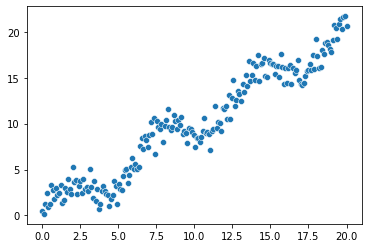

In [6]:
#Crate a 1-dimensional input
X = np.linspace(0, 20, num=200)
#create an output
y = X + np.sin(X)*2 + np.random.normal(size=X.shape)
sns.scatterplot(x=X, y=y)

In [7]:
class Simple1DRegressionDataset(Dataset):
        
    def __init__(self, X, y):
        super(Simple1DRegressionDataset, self).__init__()
        self.X = X.reshape(-1,1)
        self.y = y.reshape(-1,1)
        
    
    def __getitem__(self, index):
        return torch.tensor(self.X[index,:], dtype=torch.float32), torch.tensor(self.y[index], dtype=torch.float32)

    def __len__(self):
        return self.X.shape[0]
    
training_loader = DataLoader(Simple1DRegressionDataset(X, y), shuffle=True)

In [8]:
in_features = 1
out_features = 1
model = nn.Linear(in_features, out_features)
loss_func = nn.MSELoss()

device = torch.device("cuda")
train_simple_network(model, loss_func, training_loader, device=device)

In [9]:
with torch.no_grad():
    Y_pred = model(torch.tensor(X.reshape(-1,1), device=device, dtype=torch.float32)).cpu().numpy()

<AxesSubplot:>

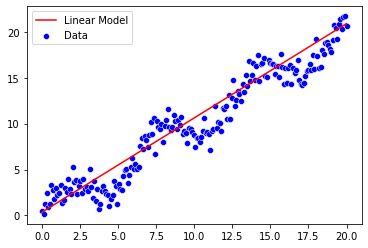

In [10]:
sns.scatterplot(x=X, y=y, color='blue', label='Data') #The data
sns.lineplot(x=X, y=Y_pred.ravel(), color='red', label='Linear Model') #What our model learned

In [11]:
#Input "layer" is implicitly the input 
model = nn.Sequential(
    nn.Linear(1,  10), #Hidden layer
    nn.Linear(10, 1), #Output layer
)

train_simple_network(model, loss_func, training_loader)

<AxesSubplot:>

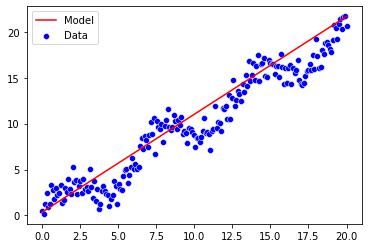

In [12]:
with torch.no_grad():
    Y_pred = model(torch.tensor(X.reshape(-1,1), dtype=torch.float32)).cpu().numpy()
    
sns.scatterplot(x=X, y=y, color='blue', label='Data') #The data
sns.lineplot(x=X, y=Y_pred.ravel(), color='red', label='Model') #What our model learned

Text(0, 0.5, 'Activation')

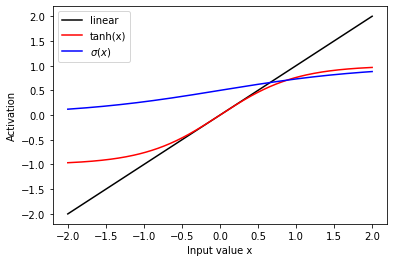

In [13]:
activation_input = np.linspace(-2, 2, num=200)
tanh_activation = np.tanh(activation_input)
sigmoid_activation = np.exp(activation_input)/(np.exp(activation_input)+1)
sns.lineplot(x=activation_input, y=activation_input, color='black', label="linear")
sns.lineplot(x=activation_input, y=tanh_activation, color='red', label="tanh(x)")
ax = sns.lineplot(x=activation_input, y=sigmoid_activation, color='blue', label="$\sigma(x)$")
ax.set_xlabel('Input value x')
ax.set_ylabel('Activation')

In [14]:
model = nn.Sequential(
    nn.Linear(1,  10),#hidden layer
    nn.Tanh(),#activation
    nn.Linear(10, 1),#output layer
)

train_simple_network(model, loss_func, training_loader, epochs=200)

<AxesSubplot:>

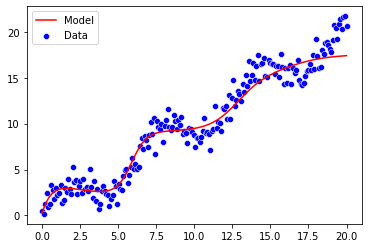

In [15]:
with torch.no_grad():
    Y_pred = model(torch.tensor(X.reshape(-1,1), dtype=torch.float32)).cpu().numpy()
    
sns.scatterplot(x=X, y=y, color='blue', label='Data') #The data
sns.lineplot(x=X, y=Y_pred.ravel(), color='red', label='Model') #What our model learned

<AxesSubplot:>

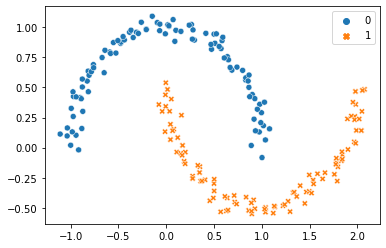

In [16]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=200, noise=0.05)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y)

In [17]:
classification_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32),
                                                        torch.tensor(y, dtype=torch.long))
training_loader = DataLoader(classification_dataset)

In [18]:
in_features = 2
out_features = 2
model = nn.Linear(in_features, out_features)

In [19]:
loss_func = nn.CrossEntropyLoss()
train_simple_network(model, loss_func, training_loader, epochs=50)

/home/edraff/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The ax attribute was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  del sys.path[0]


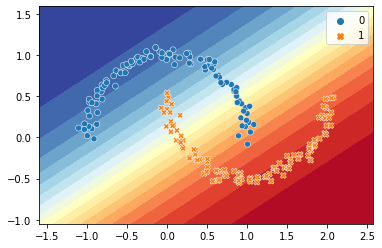

In [20]:
def visualize2DSoftmax(X, y, model, title=None):
    x_min = np.min(X[:,0])-0.5
    x_max = np.max(X[:,0])+0.5
    y_min = np.min(X[:,1])-0.5
    y_max = np.max(X[:,1])+0.5
    xv, yv = np.meshgrid(np.linspace(x_min, x_max, num=20), np.linspace(y_min, y_max, num=20), indexing='ij')
    xy_v = np.hstack((xv.reshape(-1,1), yv.reshape(-1,1)))
    with torch.no_grad():
        logits = model(torch.tensor(xy_v, dtype=torch.float32))
        y_hat = F.softmax(logits, dim=1).numpy()

    cs = plt.contourf(xv, yv, y_hat[:,0].reshape(20,20), levels=np.linspace(0,1,num=20), cmap=plt.cm.RdYlBu)
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y, ax=cs.ax)
    if title is not None:
        cs.ax.set_title(title)

visualize2DSoftmax(X, y, model)

In [21]:
model = nn.Sequential(
    nn.Linear(2,  30),
    nn.Tanh(),
    nn.Linear(30,  30),
    nn.Tanh(),
    nn.Linear(30, 2),
)
train_simple_network(model, loss_func, training_loader, epochs=250)

/home/edraff/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The ax attribute was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  del sys.path[0]


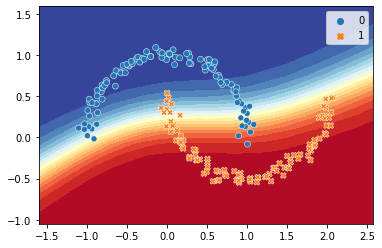

In [22]:
visualize2DSoftmax(X, y, model)

In [23]:
def run_epoch(model, optimizer, data_loader, loss_func, device, results, score_funcs, prefix="", desc=None):
    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()
    for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
        #Move the batch to the device we are using. 
        inputs = moveTo(inputs, device)
        labels = moveTo(labels, device)

        y_hat = model(inputs) #this just computed f_Θ(x(i))
        # Compute loss.
        loss = loss_func(y_hat, labels)

        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #Now we are just grabbing some information we would like to have
        running_loss.append(loss.item())

        if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            #add to predictions so far
            y_true.extend(labels.tolist())
            y_pred.extend(y_hat.tolist())
    #end training epoch
    end = time.time()
    
    y_pred = np.asarray(y_pred)
    if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
        y_pred = np.argmax(y_pred, axis=1)
    #Else, we assume we are working on a regression problem
    
    results[prefix + " loss"].append( np.mean(running_loss) )
    for name, score_func in score_funcs.items():
        try:
            results[prefix + " " + name].append( score_func(y_true, y_pred) )
        except:
            results[prefix + " " + name].append(float("NaN"))
    return end-start #time spent on epoch

In [24]:
def train_simple_network(model, loss_func, train_loader, val_loader=None, score_funcs=None, 
                         epochs=50, device="cpu", checkpoint_file=None):
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if val_loader is not None:
            to_track.append("val " + eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []
        
    #SGD is Stochastic Gradient Decent.
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
        model = model.train()#Put our model in training mode
        
        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")

        results["total time"].append( total_train_time )
        results["epoch"].append( epoch )
        
        if val_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(model, optimizer, val_loader, loss_func, device, results, score_funcs, prefix="val", desc="Testing")
                    
    if checkpoint_file is not None:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'results' : results
            }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

In [25]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [26]:
X_train, y_train = make_moons(n_samples=8000, noise=0.4)
X_test, y_test = make_moons(n_samples=200, noise=0.4)
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
training_loader = DataLoader(train_dataset, shuffle=True)
testing_loader = DataLoader(test_dataset)

In [27]:
model = nn.Sequential(
    nn.Linear(2,  30),
    nn.Tanh(),
    nn.Linear(30,  30),
    nn.Tanh(),
    nn.Linear(30, 2),
)
results_pd = train_simple_network(model, loss_func, training_loader, epochs=5, val_loader=testing_loader, checkpoint_file='model.pt', score_funcs={'Acc':accuracy_score,'F1': f1_score})

/home/edraff/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The ax attribute was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  del sys.path[0]
/home/edraff/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The ax attribute was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  from ipykernel import kernelapp as app


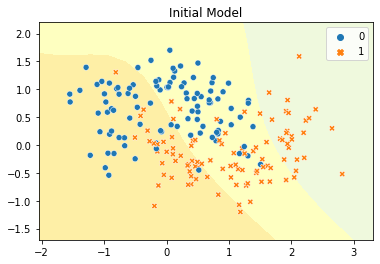

/home/edraff/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The ax attribute was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  del sys.path[0]
/home/edraff/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The ax attribute was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  from ipykernel import kernelapp as app


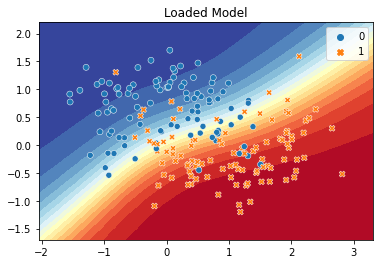

In [28]:
model_new = nn.Sequential(
    nn.Linear(2,  30),
    nn.Tanh(),
    nn.Linear(30,  30),
    nn.Tanh(),
    nn.Linear(30, 2),
)

visualize2DSoftmax(X_test, y_test, model_new, title="Initial Model")
plt.show()

checkpoint_dict = torch.load('model.pt', map_location=device)


model_new.load_state_dict(checkpoint_dict['model_state_dict'])

visualize2DSoftmax(X_test, y_test, model_new, title="Loaded Model")
plt.show()

<AxesSubplot:xlabel='epoch', ylabel='train Acc'>

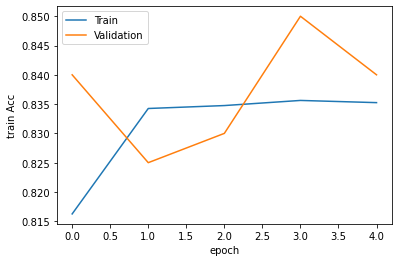

In [29]:
sns.lineplot(x='epoch', y='train Acc', data=results_pd, label='Train')
sns.lineplot(x='epoch', y='val Acc', data=results_pd, label='Validation')

<AxesSubplot:xlabel='total time', ylabel='train F1'>

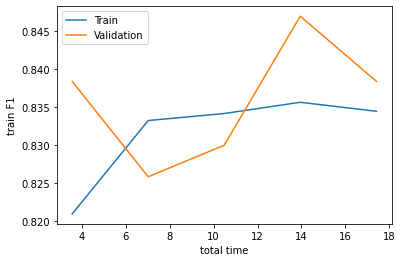

In [30]:
sns.lineplot(x='total time', y='train F1', data=results_pd, label='Train')
sns.lineplot(x='total time', y='val F1', data=results_pd, label='Validation')

In [31]:
training_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
testing_loader = DataLoader(test_dataset, batch_size=len(test_dataset))
model_gd = nn.Sequential(
    nn.Linear(2,  30),
    nn.Tanh(),
    nn.Linear(30,  30),
    nn.Tanh(),
    nn.Linear(30, 2),
)
results_true_gd = train_simple_network(model_gd, loss_func, training_loader, epochs=5, val_loader=testing_loader, checkpoint_file='model.pt', score_funcs={'Acc':accuracy_score,'F1': f1_score})

<AxesSubplot:xlabel='total time', ylabel='val Acc'>

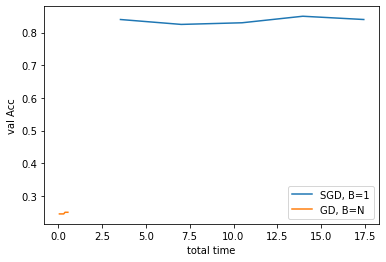

In [32]:
sns.lineplot(x='total time', y='val Acc', data=results_pd, label='SGD, B=1')
sns.lineplot(x='total time', y='val Acc', data=results_true_gd, label='GD, B=N')

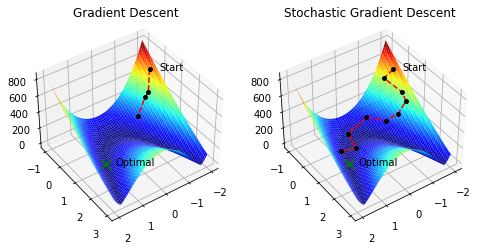

In [33]:
def rsn(x,y):
    return (1-x)**2+100*np.abs(y-x*x)**1.3

# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.5))

def forceZorder(obj, new_z):
    og_ref = obj.do_3d_projection
    def tmp(z):
        q = og_ref(z)
        return new_z
    obj.do_3d_projection = tmp
    
#===============
#  First subplot
#===============
ax = fig.add_subplot(1, 2, 1, projection='3d')

resolution = 100
x = np.outer(np.linspace(-2, 2, resolution), np.ones(resolution))
y = np.outer(np.linspace(-1, 3, resolution), np.ones(resolution)).T
#z = np.cos(x ** 2 + y ** 2)
z = rsn(x, y)

# fig = plt.figure()
# ax = plt.axes(projection='3d')

# ax.plot_surface(x, y, z, cmap='viridis', edgecolor='none')

path = np.array([[-1.87,-0.35], [-1.63,-0.07], 
                 [-1.515,-0.111], [-1.123,-0.010]])
path_z = rsn(path[:,0], path[:,1])

ax.plot_surface(x, y, z, shade=False, cmap='jet', edgecolor='none', alpha=0.95, zorder=2)
forceZorder(ax.collections[-1], 1000000)
ax.plot(path[:,0], path[:,1], zs=path_z,  linestyle='dashed', c="red", zorder=3)
#plot does not go into a "collections", but actually does use zorder... 
ax.scatter(path[:,0], path[:,1], zs=path_z, marker='.', s=60, c="black", depthshade=False, alpha=1.0, zorder=1)
forceZorder(ax.collections[-1], 98)

ax.scatter([1], [1], zs=rsn(1,1), marker='x', s=90, c="green", depthshade=False, alpha=1.0, zorder=1)
forceZorder(ax.collections[-1], 97)

ax.text(0.75, 1.25, 1, "Optimal")
ax.text(path[0,0]-0.25, path[0,1]+0.25, path_z[0], "Start")
ax.view_init(elev=40., azim=55)
ax.set_title('Gradient Descent')


#===============
#  Second subplot
#===============
ax = fig.add_subplot(1, 2, 2, projection='3d')


path = np.array([[-1.87,-0.35], [-1.63,-0.57], 
                 [-1.813,0.311], [-1.79,0.575],
                 [-1.515,0.5], [-1.152,0.212], 
                 [-0.747,-0.43], [0.14,-0.31], 
                 [0.38,0.535], [0.91,0.37]])
path_z = rsn(path[:,0], path[:,1])

# ax.plot(path[:,0], path[:,1], path_z)

ax.plot_surface(x, y, z, shade=False, cmap='jet', edgecolor='none', alpha=0.95, zorder=2)
forceZorder(ax.collections[-1], 1000000)
ax.plot(path[:,0], path[:,1], zs=path_z,  linestyle='dashed', c="red", zorder=3)
#plot does not go into a "collections", but actually does use zorder... 
ax.scatter(path[:,0], path[:,1], zs=path_z, marker='.', s=60, c="black", depthshade=False, alpha=1.0, zorder=1)
forceZorder(ax.collections[-1], 98)

ax.scatter([1], [1], zs=rsn(1,1), marker='x', s=90, c="green", depthshade=False, alpha=1.0, zorder=1)
forceZorder(ax.collections[-1], 97)

ax.text(0.75, 1.25, 1, "Optimal")
ax.text(path[0,0]-0.25, path[0,1]+0.25, path_z[0], "Start")
ax.view_init(elev=40., azim=55)
ax.set_title('Stochastic Gradient Descent')

plt.show()

In [34]:
training_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
model_sgd = nn.Sequential(
    nn.Linear(2,  30),
    nn.Tanh(),
    nn.Linear(30,  30),
    nn.Tanh(),
    nn.Linear(30, 2),
)
results_batched = train_simple_network(model_sgd, loss_func, training_loader, epochs=5, val_loader=testing_loader, checkpoint_file='model.pt', score_funcs={'Acc':accuracy_score,'F1': f1_score})

<AxesSubplot:xlabel='total time', ylabel='val Acc'>

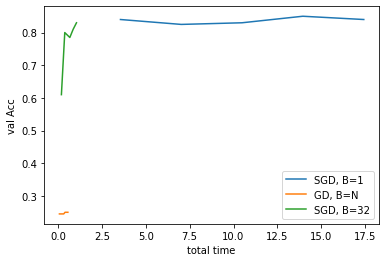

In [35]:
sns.lineplot(x='total time', y='val Acc', data=results_pd, label='SGD, B=1')
sns.lineplot(x='total time', y='val Acc', data=results_true_gd, label='GD, B=N')
sns.lineplot(x='total time', y='val Acc', data=results_batched, label='SGD, B=32')